In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from scipy import sparse, stats
from spatialpower.neighborhoods import permutationtest as perm_test
#from spatialpower.neighborhoods.neighborhoods import run_test
import networkx as nx
from datetime import datetime
import errno
from joblib import Parallel, delayed
from matplotlib.colors import ListedColormap

In [6]:
def motif_test(results_path, A, B, H_gt, size, n_jobs, trials, plot, graph, graph_id, threshold):
    '''
    Runs the permutation test, and calculates signficant interaction pairs.

    Parameters
    ----------
        results_path: str, the root results dir
        size : int, size of graph to calculate.
        n_jobs: int, number of parallel jobs to spawn
        trials: int, number of shuffles in empirical distribution
        plot : bool, generate histogram of each pairwise relation if True.

    Returns
    -------
        None
    '''
    # Make results dir
    try:
        os.mkdir(results_path)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass

    # Perform calculations.
    results = []
    '''if graph_id == None:
        out_dir = results_path + '/' + str(size) + '_cells/'
    else:
        out_dir = results_path + '/' + str(size) + '_cells_' + str(graph_id) + '/'

    try:
        os.mkdir(out_dir)
    except OSError as exc:
        if exc.errno != errno.EEXIST:
            raise
        pass'''
    
    n_cell_types = B.shape[1]
    args = (A, B, size, graph, n_cell_types)
    arg_list = [args for i in range(0, trials)]
    results = Parallel(n_jobs=n_jobs, verbose=1, backend="sequential")(
        delayed(perm_test.permutation_test_trial_wrapper)(args) for args in arg_list)
    #parse_results(results, size, out_dir)

    # Process results

    '''# size_list = []
    result_list = []

    file_list = glob(out_dir + '*.npy')
    for f in file_list:
        arr = np.load(f)
        # size_list.append(size)
        result_list.append(arr)'''

    arr = np.dstack(results)  # stack into a 3-D array
    n_types = arr.shape[0]

    enriched_pairs = []

    for i in range(0, n_types):
        for j in range(0, n_types):
            ground_truth_score = H_gt[i, j]
            emp_dist = arr[i, j, :]
            indices, = np.where(emp_dist < ground_truth_score)
            p = (len(emp_dist) - len(indices) + 1) / (len(emp_dist) + 1)
            enriched_pairs.append([i, j, p])
        
            # Visualize empirical distribution
            if plot == True:
                plt.clf()
                # sns.set(style = 'white')
                plt.hist(arr[2, 2, :], color='k')
                plt.xlim(0, 1)
                plt.xlabel("Probability of Interaction between " + str(i) + " and " + str(j))
                plt.ylabel("Count")
                plt.savefig(out_dir + "distplot_" + str(i) + "_" + str(j) + ".pdf")

    # Write results matrix.
    #np.save(out_dir + "pairs.npy", np.array(enriched_pairs))

    return np.array(enriched_pairs)

In [7]:
results_dir = './results/motif_detection/'
adj_matrix_list = np.sort(glob(results_dir + '/*network*.npy'))
ass_matrix_list = np.sort(glob(results_dir + 'selfpref_random/*B*.npy'))

In [ ]:
results = []
for i in range(0, len(ass_matrix_list)):
    if i%10 == 0:
        print(i)
        
    if i >= 25:
        A = np.load(adj_matrix_list[i-25])
    else:
        A = np.load(adj_matrix_list[i])
    
    B = np.load(ass_matrix_list[i])

    S = sparse.coo_matrix(A)
    S_csc = S.tocsc()

    graph = nx.from_numpy_array(A)
    
    H_gt = perm_test.calculate_neighborhood_distribution_sparse(S_csc,B)
    pairs = motif_test(results_dir, S_csc, B, H_gt, S_csc.shape[0], -1, 1000, False, graph, None, 0.01)
    results.append(pairs)

all_results = np.dstack(results)

In [9]:
interaction_scores = all_results[:,2,:].T
interaction_scores[interaction_scores <= 0.01] = -1
interaction_scores[interaction_scores >= 0.99] = 1
idx = np.where((interaction_scores < 0.99) & (interaction_scores > 0.01))
interaction_scores[idx] = 0

<Figure size 640x480 with 0 Axes>

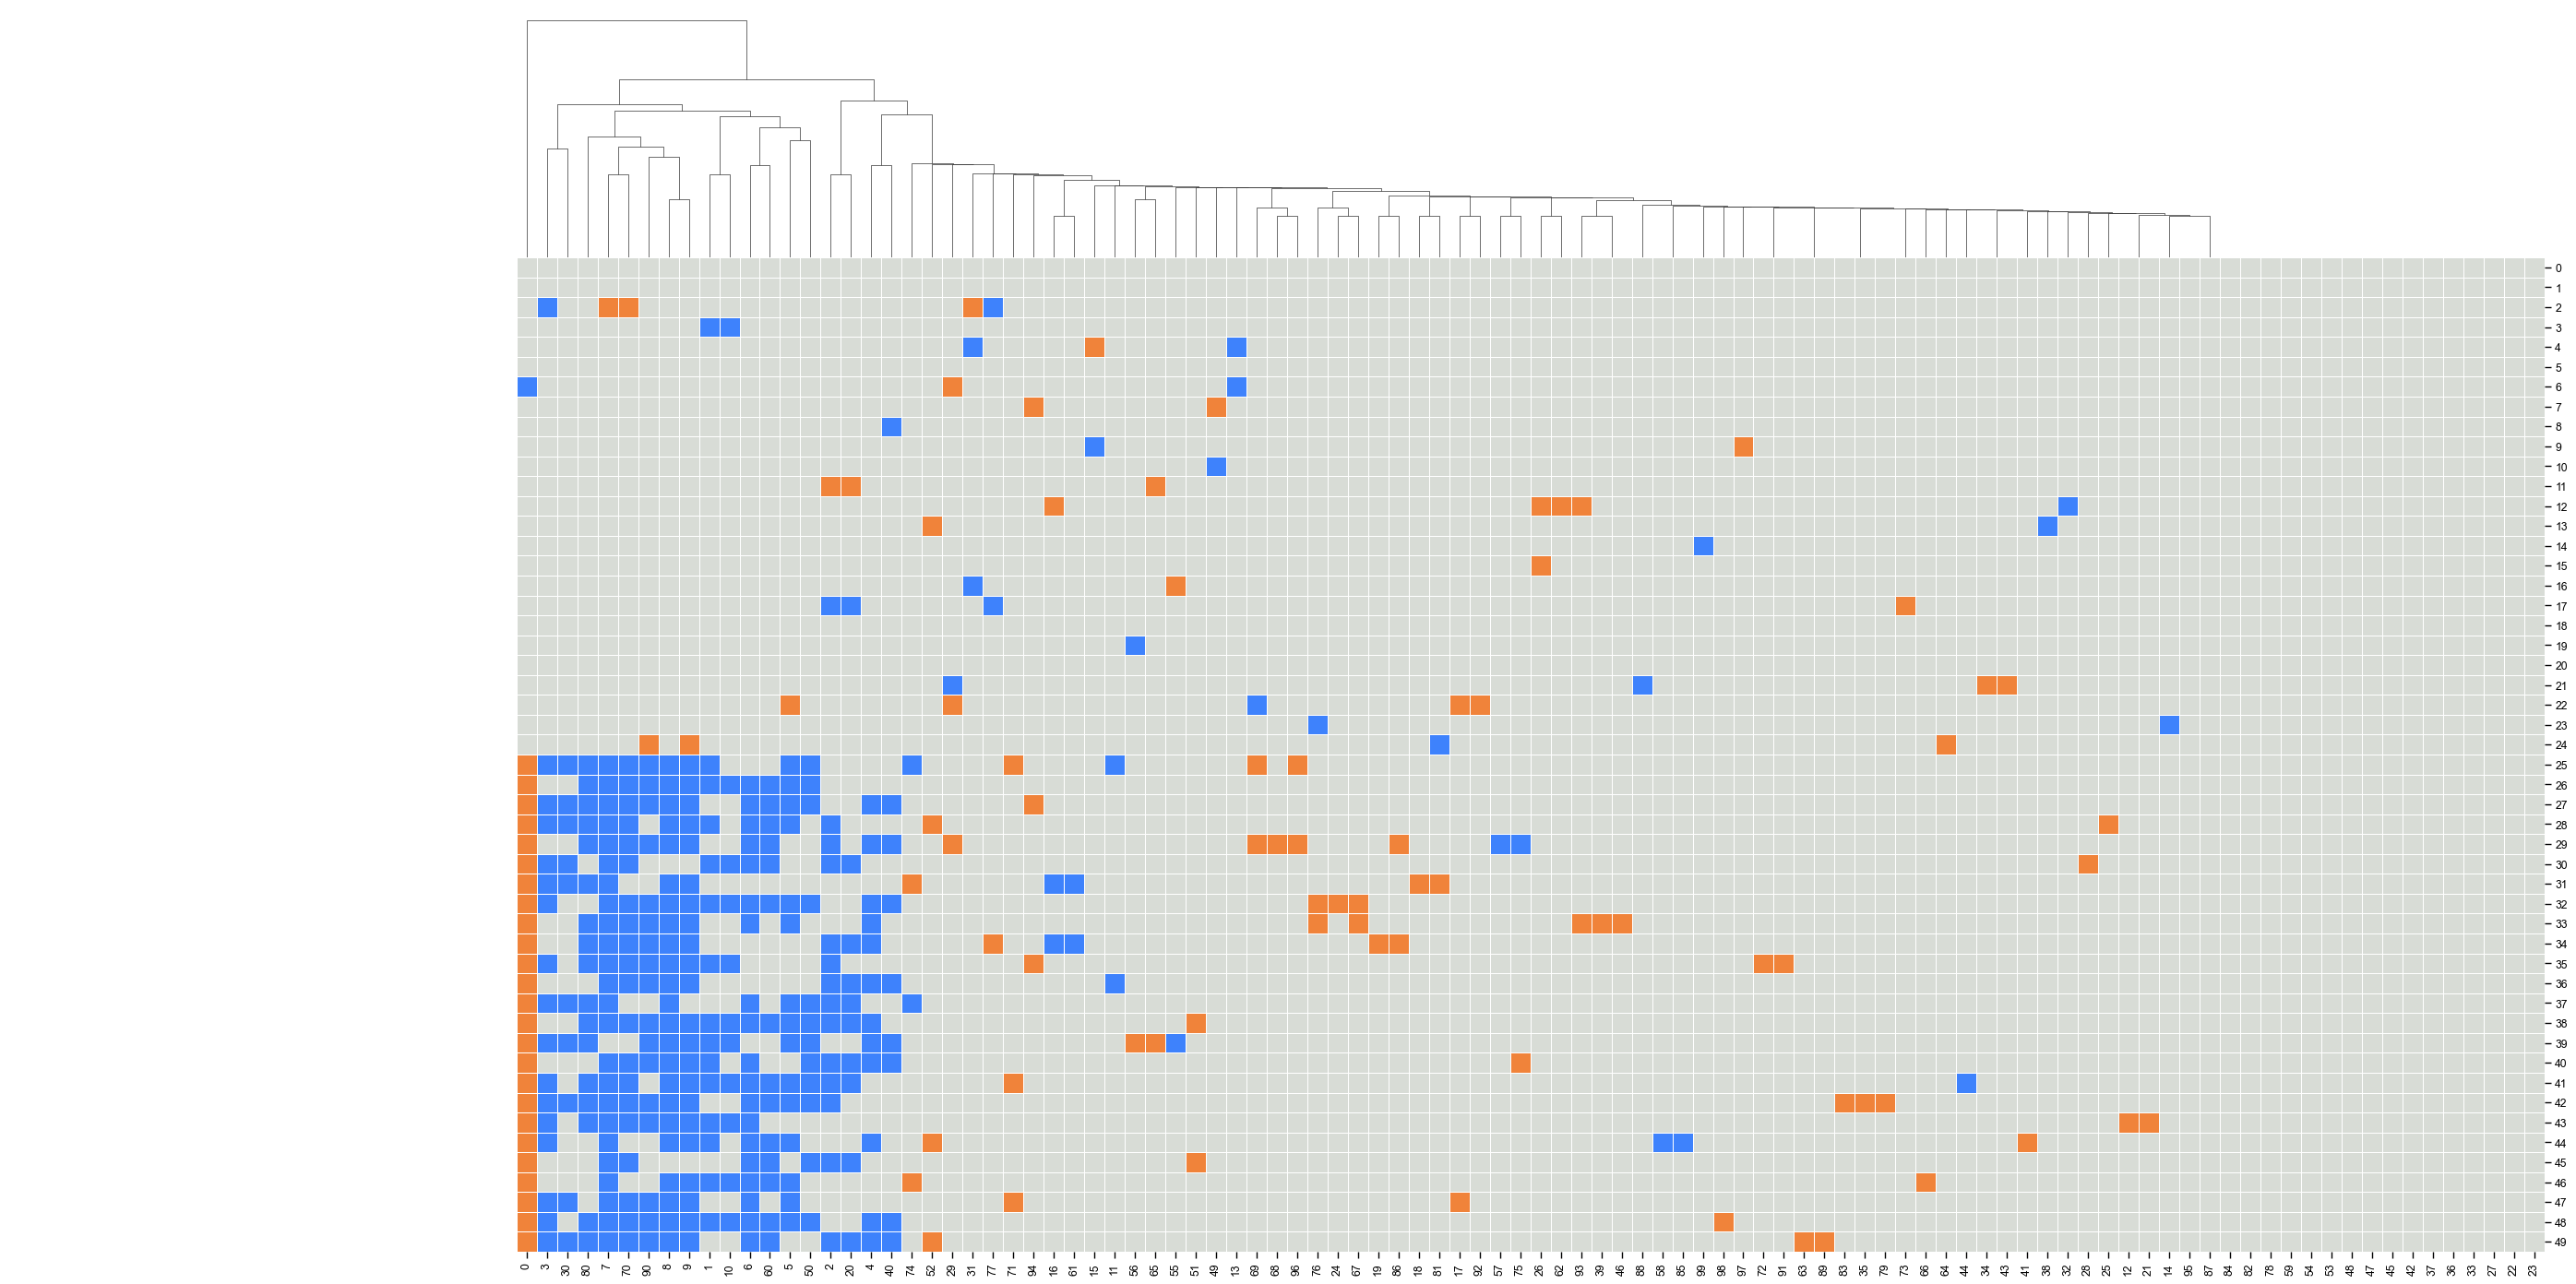

In [10]:
import matplotlib
from matplotlib import cm, colors
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

plt.clf()

#cbar_ax = plt.gca()
#sns.clustermap(data, cbar_ax=cbar_ax)
#cmap = sns.cubehelix_palette(start=2.8, rot=.1, light=0.9, n_colors=3)
sns.set_context("paper")
colors = ["dusty orange", "light grey", "dodger blue"]
#sns.palplot(sns.xkcd_palette(colors))

cmap = sns.xkcd_palette(colors)
g = sns.clustermap(interaction_scores, method = 'average', row_cluster=False, figsize=(28,14), cmap = ListedColormap(cmap), linewidths=.5, linecolor='white')
g.cax.set_visible(False) 
#plt.tight_layout()
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
#plt.savefig('./results/motif_detection/selfpref_random/clustermap.pdf')
plt.show()

In [11]:
all_results = np.dstack(results)
interaction_scores = all_results[:,2,:].T

alpha = 0.01 # Sig Threshold

frac_sig = []
for ixn_id in range(0, interaction_scores.shape[1]):
    null_cluster_scores = interaction_scores[:, ixn_id][:25]
    feature_cluster_scores = interaction_scores[:, ixn_id][25:]
    frac_sig.append([ixn_id, 0, 0])
    for j in range(2, len(null_cluster_scores) + 1):
        p_vals = []
        for k in range(0, 100):
            sample_null = np.random.choice(null_cluster_scores, size = j)
            sample_feature = np.random.choice(feature_cluster_scores, size = j)
            _, p = stats.ttest_ind(sample_null, sample_feature)
            p_vals.append(p)
        
        idx, = np.where(np.array(p_vals) < alpha)
        frac_sig.append([ixn_id, j, len(idx)/100.])
        
frac_sig = np.array(frac_sig)
    


<Figure size 640x480 with 0 Axes>

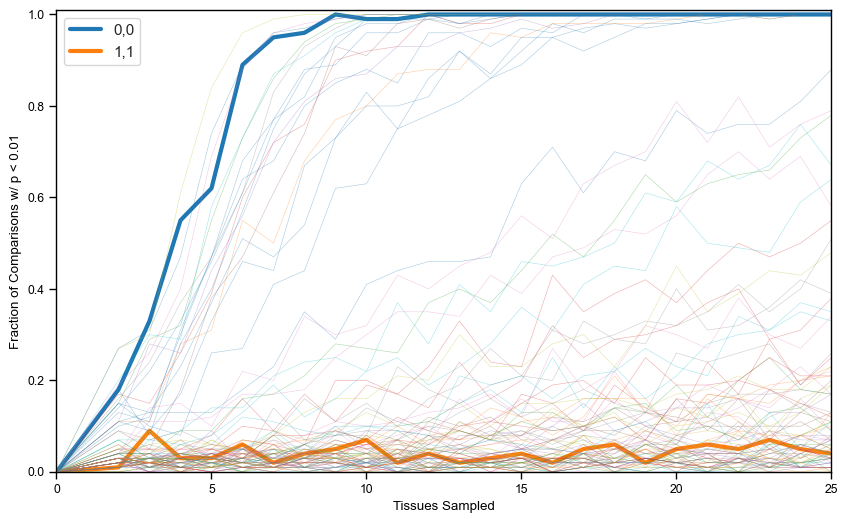

In [12]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(10,6))
pal = sns.color_palette(palette='colorblind', n_colors=12)
sns.set(style = 'whitegrid', palette=pal, color_codes=False)

for ixn_id in range(0, interaction_scores.shape[1]):
    idx, = np.where(frac_sig[:,0] == ixn_id)
    subset = frac_sig[idx]
    
    if ixn_id in [0, 11]:
        if ixn_id == 0:
            l = "0,0"
        else:
            l = '1,1'
        ax.plot(subset[:,1], subset[:,2], label = l, alpha = 1., linewidth = 3)
    else:
        ax.plot(subset[:,1], subset[:,2], label = None, alpha = 0.4, linewidth = 0.4)
    
plt.legend()
ax.set_xlabel('Tissues Sampled')
ax.set_ylabel('Fraction of Comparisons w/ p < 0.01')
ax.set_xlim((0,25))
ax.set_ylim((0,1.01))
#plt.savefig('./results/motif_detection/selfpref_random/t_test_all_ixns_motif_discovery.pdf')

plt.show()

# 3 Type Motif

In [13]:
results_dir = './results/motif_detection/'
adj_matrix_list = np.sort(glob(results_dir + '/*network*.npy'))
ass_matrix_list = np.sort(glob(results_dir + '3cell_motif/*B*.npy'))

In [ ]:
results = []
for i in range(0, len(ass_matrix_list)):
    if i%5 == 0:
        print(i)
        
    if i >= 25:
        A = np.load(adj_matrix_list[i-25])
    else:
        A = np.load(adj_matrix_list[i])
    
    B = np.load(ass_matrix_list[i])

    S = sparse.coo_matrix(A)
    S_csc = S.tocsc()

    graph = nx.from_numpy_array(A)
    
    H_gt = perm_test.calculate_neighborhood_distribution_sparse(S_csc,B)
    pairs = motif_test(results_dir, S_csc, B, H_gt, S_csc.shape[0], -1, 1000, False, graph, None, 0.01)
    results.append(pairs)

all_results = np.dstack(results)


In [16]:
interaction_scores = all_results[:,2,:].T
interaction_scores[interaction_scores <= 0.01] = -1
interaction_scores[interaction_scores >= 0.99] = 1
idx = np.where((interaction_scores < 0.99) & (interaction_scores > 0.01))
interaction_scores[idx] = 0

<Figure size 640x480 with 0 Axes>

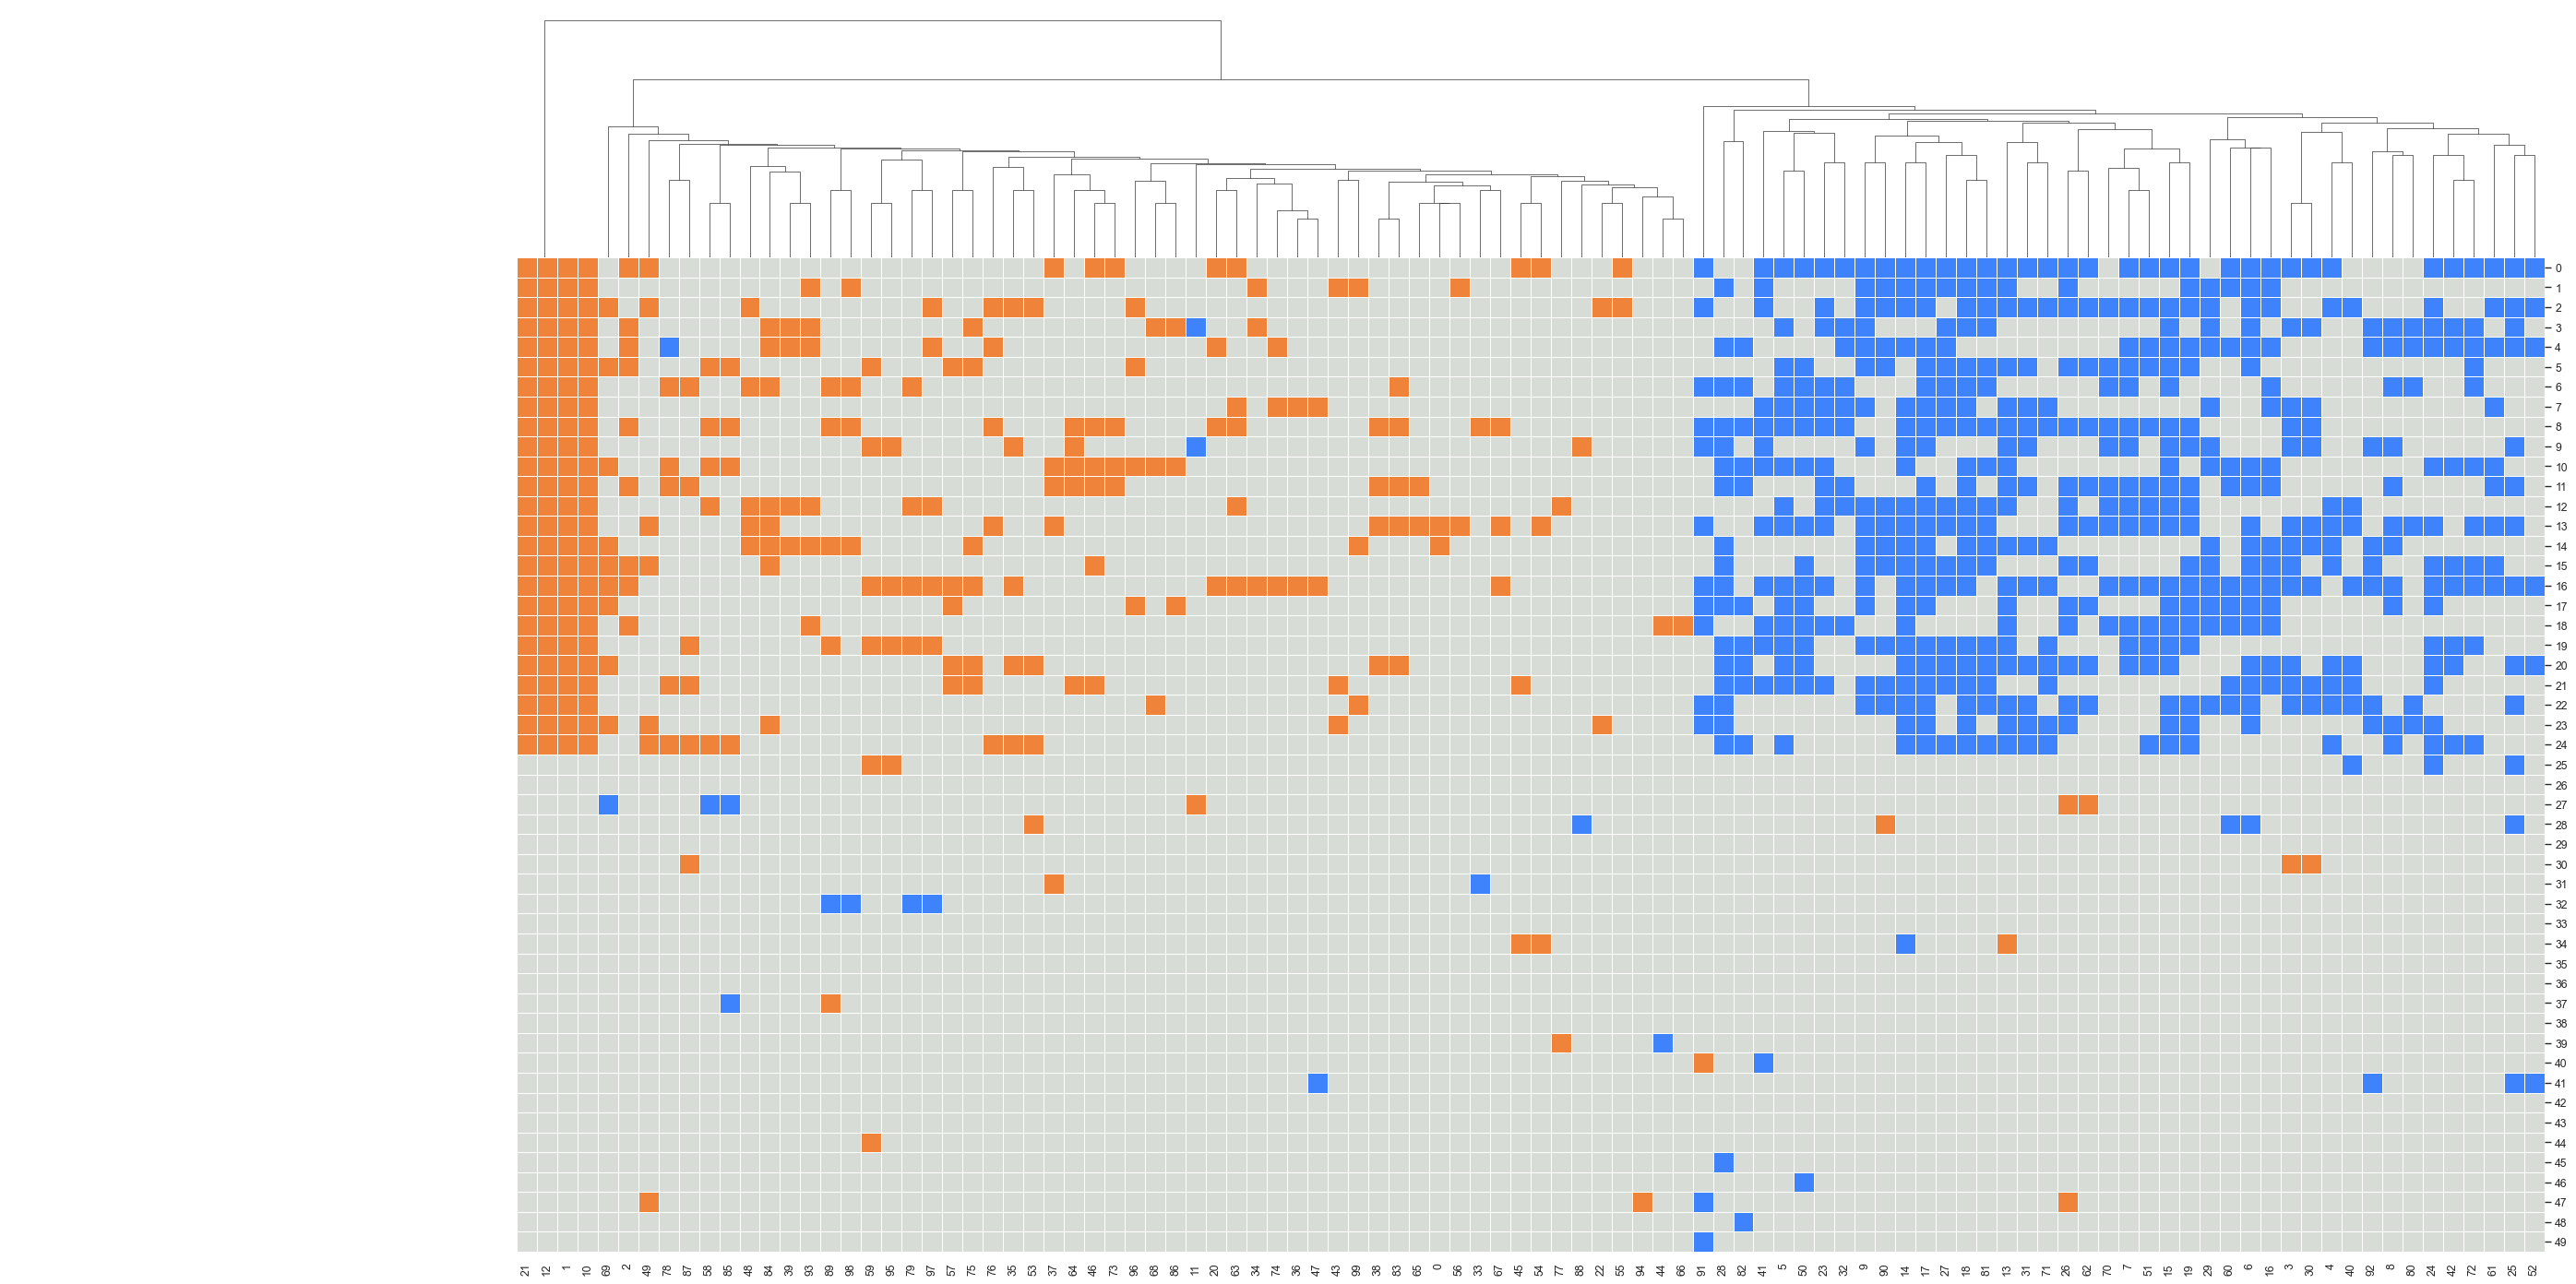

In [17]:
import matplotlib
from matplotlib import cm, colors
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

plt.clf()
#cbar_ax = plt.gca()
#sns.clustermap(data, cbar_ax=cbar_ax)
#cmap = sns.cubehelix_palette(start=2.8, rot=.1, light=0.9, n_colors=3)
sns.set_context("paper")
colors = ["dusty orange", "light grey", "dodger blue"]
#sns.palplot(sns.xkcd_palette(colors))

cmap = sns.xkcd_palette(colors)
g = sns.clustermap(interaction_scores, figsize=(28,14), method = 'average', row_cluster=False, cmap = ListedColormap(cmap), linewidths=.5, linecolor='white')
g.cax.set_visible(False) 
#plt.tight_layout()
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
#plt.savefig('./results/FigureS8B.pdf')
plt.show()

In [18]:
all_results = np.dstack(results)
interaction_scores = all_results[:,2,:].T

alpha = 0.01 # Sig Threshold

frac_sig = []
for ixn_id in range(0, interaction_scores.shape[1]):
    null_cluster_scores = interaction_scores[:, ixn_id][:25]
    feature_cluster_scores = interaction_scores[:, ixn_id][25:]
    frac_sig.append([ixn_id, 0, 0])
    for j in range(2, len(null_cluster_scores) + 1):
        p_vals = []
        for k in range(0, 100):
            sample_null = np.random.choice(null_cluster_scores, size = j)
            sample_feature = np.random.choice(feature_cluster_scores, size = j)
            _, p = stats.ttest_ind(sample_null, sample_feature)
            p_vals.append(p)
        
        idx, = np.where(np.array(p_vals) < alpha)
        frac_sig.append([ixn_id, j, len(idx)/100.])
        
frac_sig = np.array(frac_sig)
    

<Figure size 640x480 with 0 Axes>

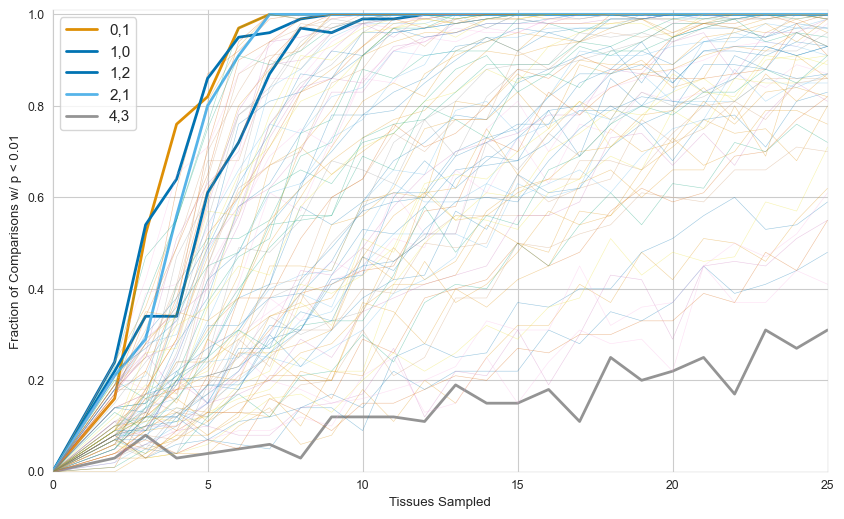

In [19]:
import matplotlib
from matplotlib import cm, colors
import matplotlib.pyplot as plt

matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(10,6))
pal = sns.color_palette(palette='colorblind', n_colors=8)
sns.set(style = 'whitegrid', palette=pal, color_codes=False)

for ixn_id in range(0, interaction_scores.shape[1]):
    idx, = np.where(frac_sig[:,0] == ixn_id)
    subset = frac_sig[idx]
    
    if ixn_id in [10,21,1,12, 43]:
        if ixn_id == 10:
            l = "1,0"
        elif ixn_id == 1:
            l = "0,1"
        elif ixn_id == 12:
            l = "1,2"
        elif ixn_id == 21:
            l = "2,1"
        else:
            l = "4,3"
        ax.plot(subset[:,1], subset[:,2], label = l, alpha = 1., linewidth = 2)
    else:
        ax.plot(subset[:,1], subset[:,2], label = None, alpha = 0.4, linewidth = 0.4)
    
plt.legend()
ax.set_xlabel(r'Tissues Sampled')
ax.set_ylabel(r'Fraction of Comparisons w/ p < 0.01')
ax.set_xlim((0,25))
ax.set_ylim((0,1.01))
#plt.savefig('./results/motif_detection/3cell_motif/t_test_all_ixns_motif_discovery.pdf')
plt.show()